In [1]:
import matplotlib.pyplot as plt
from brian2.only import *
import deepdish as dd

%load_ext autoreload
%autoreload 1

%aimport numpy_
%aimport spatial
%aimport model
%aimport inputs
%aimport readout

# for the IDE:
import numpy_ as np
import spatial, model, inputs, readout

In [2]:
templ = net = 0
pair = 0
istim, stim = 0, 'A'
ISIs = (100, 300, 500, 750, 1000)
fbase = 'data/isi1_'
fname = fbase + 'net{net}_isi{isi}_STD{STD}_TA{TA}_templ{templ}.h5'
idxfile = fbase + 'idx.h5'
netfile = fbase + 'net{net}.h5'
conds = ('std', 'dev', 'msc')

In [3]:
sml = (100, 500, 1000)

In [4]:
params = None
results = {}
for STD in range(2):
    results[STD] = {}
    for TA in range(2):
        results[STD][TA] = {}
        for isi in sml:
            res = dd.io.load(fname.format(**locals()))
            if params is None:
                params = res['params']
            results[STD][TA][isi] = res['results'][pair][stim]

# Voltage space measures

In [5]:
def get_onset_ordering(results_list, limit=None, filter=None):
    hist_sum = np.sum([r[cond]['spike_hist'] for r in results_list for cond in conds], axis=0)
    first_index = np.sum(np.cumsum(hist_sum, axis=1) == 0, axis=1)
    safe_first_index = first_index.copy()
    safe_first_index[first_index >= hist_sum.shape[1]] = 0
    first_intensity = hist_sum[np.arange(hist_sum.shape[0]), safe_first_index]
    onset_sort = np.lexsort((-first_intensity, first_index))
    order = onset_sort[:limit]
    if filter is not None:
        order = order[np.isin(order, filter)]
    tmax = np.flatnonzero(hist_sum[order].sum(axis=0))[-1] + 1
    return order, tmax

In [6]:
def time(ticks):
    return ticks*params['dt'] / msecond

In [7]:
def plot_pulse_hist(histograms, selection, tmax, figsize=(10,15), grid=False, cmap='PiYG', vmin=None, vmax=None, symmetric=True, cscale=False):
    histograms = np.asarray(histograms)
    x = time(np.arange(tmax+1))
    y = np.arange(len(selection)+1)
    if symmetric:
        if vmax is None:
            vmax = np.nanmax(np.abs(histograms))
        if vmin is None:
            vmin = -vmax
    else:
        if vmax is None:
            vmax = np.nanmax(histograms)
        if vmin is None:
            vmin = np.nanmin(histograms)

    fig, axs = plt.subplots(1, len(histograms), figsize=figsize, sharex=True, sharey=True, constrained_layout=True, squeeze=False)
    axs = axs[0]
    orders = []
    for ax, hist in zip(axs, histograms):
        h = hist[selection, :tmax]
        order = 0
        if cscale:
            hmax, hmin = np.nanmax(h), np.nanmin(h)
            max_order = int(np.log10(vmax/hmax)) if hmax>0 else np.nan
            min_order = int(np.log10(vmin/hmin)) if hmin<0 else np.nan
            order = np.nanmin([max_order, min_order])
            if np.isnan(order):
                order = 1
        orders.append(order)
        m = ax.pcolormesh(x, y, h*10**order, vmin=vmin, vmax=vmax, cmap=cmap, shading='flat')
        ax.set_xlabel('Time after pulse onset (ms)')
        if grid:
            ax.grid()
    axs[0].set_ylabel('Neuron #')
    cb = plt.colorbar(m, location='bottom', ax=axs, aspect=40, fraction=1/figsize[1], pad=.5/figsize[1])

    if cscale:
        return fig, axs, orders, cb
    else:
        return fig, axs, cb

In [8]:
from matplotlib.colors import LinearSegmentedColormap
# From http://www.ccctool.com/html_v_0_9_0_3/CCC_Tool/cccTool.html
ccc_divergent = LinearSegmentedColormap.from_list('ccc_divergent', list(zip([0, .16, .35, .5, .62, .8, 1],
np.asarray([
    [.0862745098039216,0.00392156862745098,0.298039215686275, 1.],
    [.054902,0.317647,0.709804, 1.],
    [.0705882,0.854902,0.870588, 1.],
    [1, 1, 1, 1.],
    [.94902,0.823529,0.321569, 1.],
    [.811765,0.345098,0.113725, 1.],
    [.188235294117647,0,0.0705882352941176, 1.]
]))))

In [9]:
selection, tmax = get_onset_ordering([r for rs in results.values() for rt in rs.values() for r in rt.values()])

In [10]:
def get_voltages(params, results):
    depression = results['u'] - results['v']
    threshold = results['th_adapt']
    activity = results['u'] - params['v_threshold']
    activity[activity >= threshold+depression] = np.nan
    return activity*1000, depression*1000, threshold*1000 # -> mV

In [11]:
def get_early_contrib(contrast):
    norm = sum([np.abs(c) for c in contrast.values()])
    norm[norm < 1e-3] = np.nan
    early_contrib = {}
    # Find the first bin where activity > 75%, per neuron:
    t_early_nrn = np.sum(np.cumsum(np.abs(contrast['Activity']/norm) > .75, axis=1) == 0, axis=1)
    for measure, c in contrast.items():
        # Sum target contributions up to that bin:
        neuron_early_contrib = np.nancumsum(np.abs(c), 1)[np.arange(c.shape[0]), t_early_nrn-1]
        numbins = np.cumsum(~np.isnan(c), 1)[np.arange(c.shape[0]), t_early_nrn-1]
        # Remove faulty values (where bin 0 already has activity > 75%)
        neuron_early_contrib[t_early_nrn==0] = 0
        numbins[t_early_nrn==0] = 0
        # Grand mean
        early_contrib[measure] = neuron_early_contrib.sum() / numbins.sum()
    return early_contrib

In [12]:
voltage_measures = measures = ('Activity', 'Depression', 'Threshold')
voltages = {}
max_activity = -100
for STD in range(2):
    voltages[STD] = {}
    for TA in range(2):
        voltages[STD][TA] = {}
        for isi in sml:
            voltages[STD][TA][isi] = {}
            for cond in conds:
                voltages[STD][TA][isi][cond] = {}
                a, d, th = get_voltages(params, results[STD][TA][isi][cond])
                for measure, v in zip(('Activity', 'Depression', 'Threshold'), (a, d, th)):
                    voltages[STD][TA][isi][cond][measure] = v
                max_activity = max(np.max(d + th), max_activity)

for vSTD in voltages.values():
    for vTA in vSTD.values():
        for vISI in vTA.values():
            for vCond in vISI.values():
                vCond['Activity'][np.isnan(vCond['Activity'])] = max_activity

In [13]:
hists = {STD: {TA: {isi: {cond: {**{measure: v.mean(1) for measure, v in vCond.items()}, 'p(spike)': results[STD][TA][isi][cond]['spike_hist']}
                          for cond, vCond in vISI.items()}
                    for isi, vISI in vTA.items()}
               for TA, vTA in vSTD.items()}
         for STD, vSTD in voltages.items()}
measures = ('p(spike)', *measures)

In [14]:
width, height = 5, 10
conds = ('dev', 'msc', 'std')

In [15]:
np.seterr(divide='ignore');

In [16]:
def grouped_bars(series, xlabels, slabels, ax):
    x = np.arange(len(xlabels))  # the label locations
    n = len(series)
    w0 = 0.7
    width = w0/n  # the width of the bars

    for i, (s, label) in enumerate(zip(series, slabels)):
        ax.bar(x - w0/2 + i*width, s, width, label=label)

    ax.set_xticks(x, xlabels)
    ax.legend()

In [17]:
def compare_raw(voltages, pspikes, title, masked=False):
    if masked:
        masks = [(v['Activity'] >= 0).astype(float) for v in voltages.values()]
        for m in masks:
            m[m==0] = np.nan
        hmasks = {k: ((v['Activity'] >= 0).sum(1) > 0).astype(float) for k, v in voltages.items()}
        for m in hmasks.values():
            m[m==0] = np.nan
        for k, p in pspikes.items():
            assert p[np.isnan(hmasks[k])].sum() == 0
    else:
        masks = [1]*len(voltages)
        hmasks = {k: np.ones((1,1)) for k in voltages.keys()}
    
    fig, axs, cb = plot_pulse_hist(
        [p * hmasks[k] for k, p in pspikes.items()], selection, tmax,
        figsize=(width*len(voltages), height), symmetric=False, cmap='turbo')
    for ax, key in zip(axs, voltages.keys()):
        ax.set_title(key)
    fig.suptitle(f'{title}\np(spike)')
    cb.set_label(f'{title}\np(spike)')
    
    for measure in voltage_measures:
        fig, axs, cb = plot_pulse_hist(
            [np.nanmean(v[measure] * m, 1) for v, m in zip(voltages.values(), masks)], selection, tmax,
            figsize=(width*len(voltages), height), symmetric=False, cmap='turbo')
        for ax, key in zip(axs, voltages.keys()):
            ax.set_title(key)
        fig.suptitle(f'{title}\n{measure}')
        cb.set_label(f'{title}\n{measure}')
    plt.show()
    plt.close('all')

In [18]:
def compare_direct(voltages, pspikes, contrast_keys, title, masked=False):
    if masked:
        masks = {k: (v['Activity'] >= 0).sum(1) > 0 for k, v in voltages.items()}
        for c0, c1 in contrast_keys:
            mask = (masks[c0] | masks[c1]).astype(float)
            mask[mask==0] = np.nan
            assert (pspikes[c0] - pspikes[c1])[np.isnan(mask)].sum() == 0
            masks[(c0,c1)] = mask
    else:
        masks = {c: 1 for c in contrast_keys}
    
    # p(spike)
    fig, axs, cb = plot_pulse_hist(
        [(pspikes[c0] - pspikes[c1])*masks[(c0,c1)] for c0,c1 in contrast_keys], selection, tmax,
        figsize=(width*len(contrast_keys), height), symmetric=True, cmap=ccc_divergent)
    for ax, (c0,c1) in zip(axs, contrast_keys):
        ax.set_title(f'{c0}-{c1}')
    fig.suptitle(f'{title}\np(spike)')
    cb.set_label(f'{title}\np(spike)')


    # voltages
    contribs = []
    for c0, c1 in contrast_keys:
        # voltages
        contrast = {measure: (voltages[c0][measure].mean(1) - voltages[c1][measure].mean(1))*masks[(c0,c1)] for measure in voltage_measures}
        fig, axs, orders, cb = plot_pulse_hist(
            list(contrast.values()), selection, tmax,
            figsize=(width*len(voltage_measures), height), symmetric=True, cmap=ccc_divergent, cscale=True)
        for ax, order, measure in zip(axs, orders, contrast.keys()):
            if order:
                ax.set_title(f'{measure} * 10^{order}')
            else:
                ax.set_title(measure)
        fig.suptitle(f'{title}\n{c0}-{c1}')
        cb.set_label(f'{title}\n{c0}-{c1}')

        contribs.append(get_early_contrib(contrast))
    
    # Contributions
    fig, ax = plt.subplots(figsize=(width, 5))
    grouped_bars([list(c.values()) for c in contribs], list(contribs[0].keys()), [f'{c0}-{c1}' for c0,c1 in contrast_keys], ax)
    ax.set_ylabel('Abs contrib diff (mV)')
    ax.set_title(f'{title}\nEarly contributions')
    plt.show()
    plt.close('all')

## Sequence: dev-msc

In [19]:
V = voltages[1][1][500]
H = {cond: results[1][1][500][cond]['spike_hist'] for cond in conds}
title = 'STD 1, TA 1, 500 ms ISI'

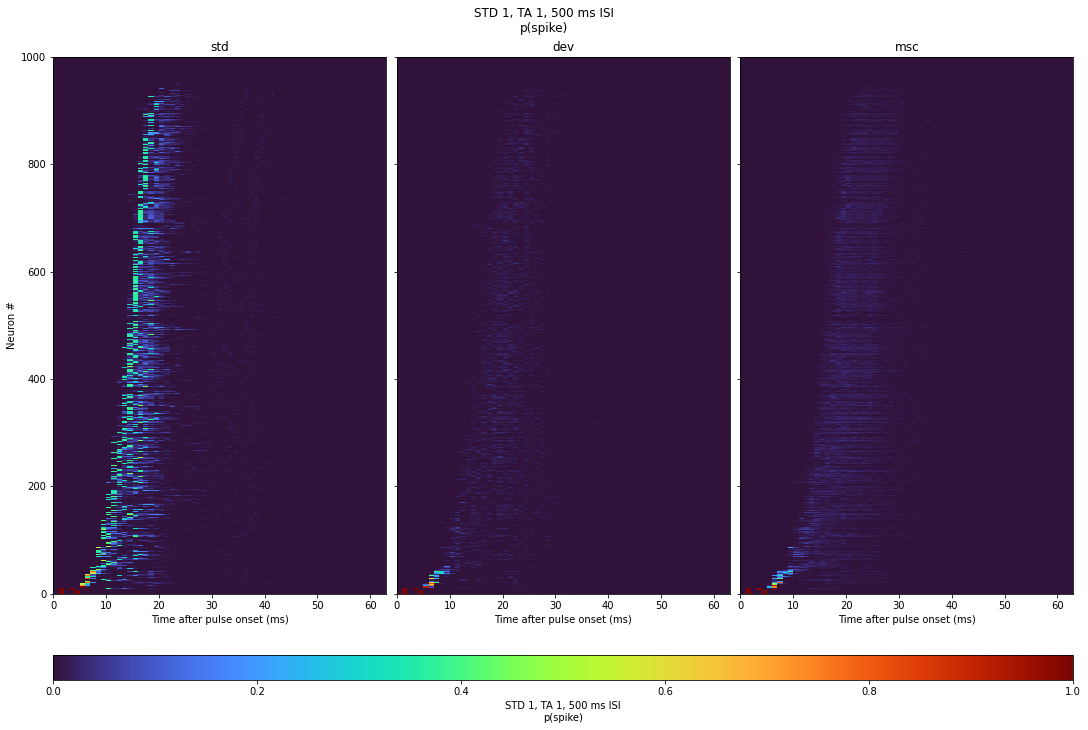

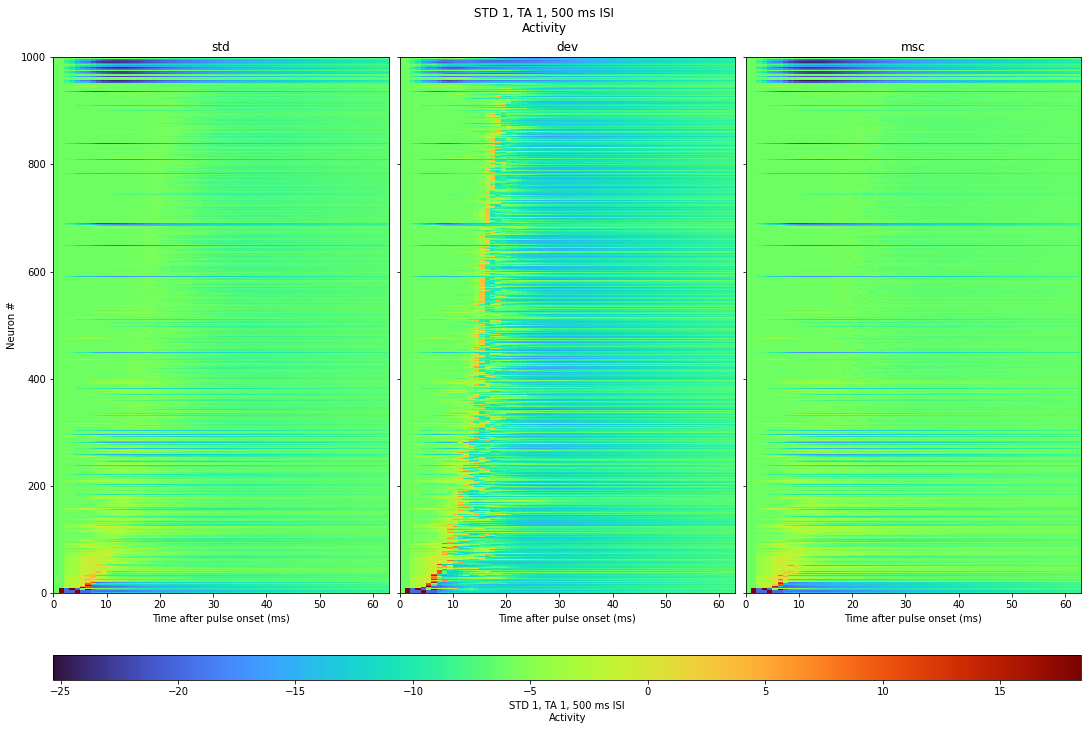

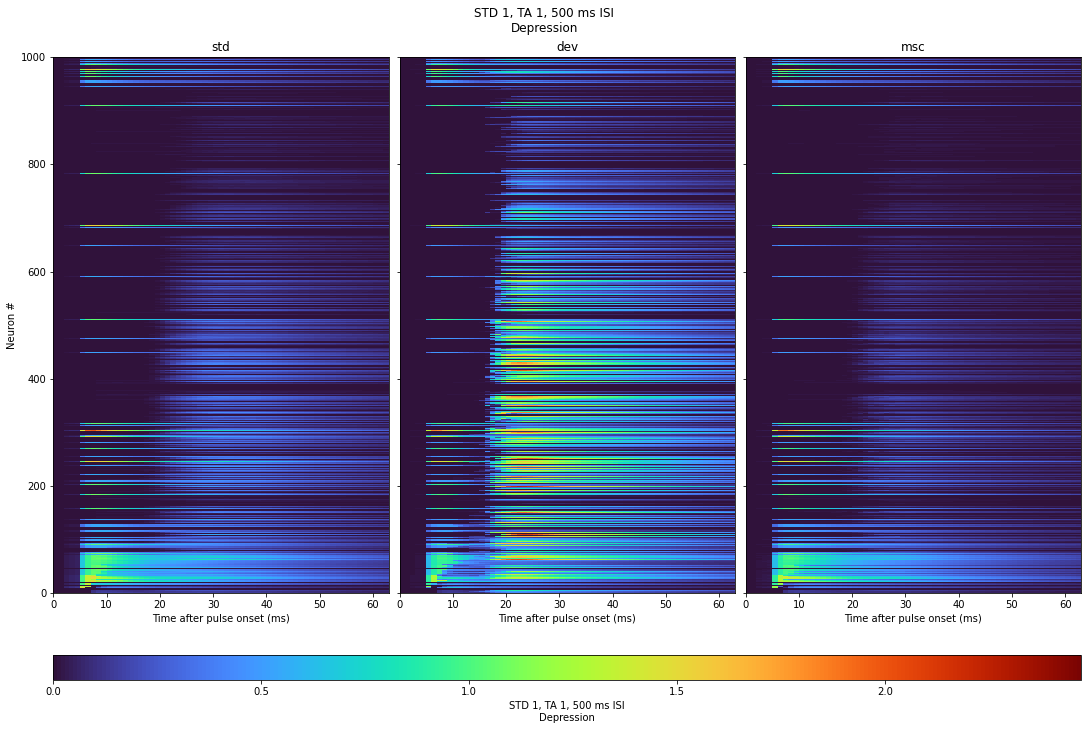

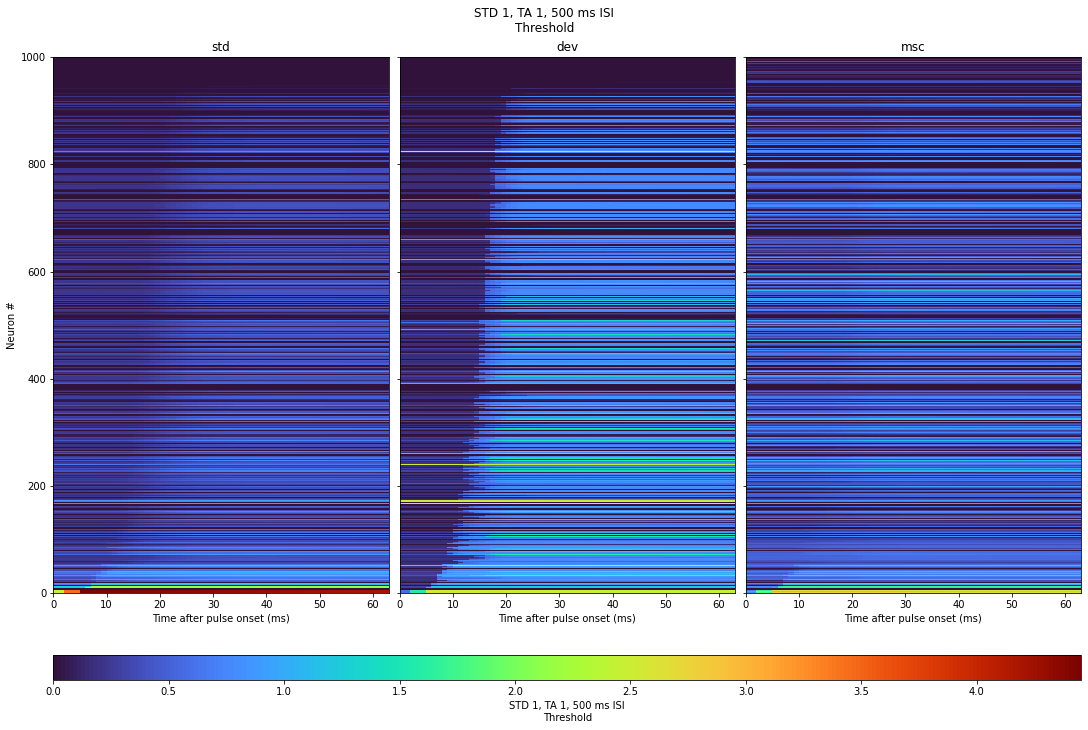

In [20]:
compare_raw(V, H, title, False)

WARNING    /tmp/ipykernel_134217/1179753402.py:25: RuntimeWarning: Mean of empty slice
  [np.nanmean(v[measure] * m, 1) for v, m in zip(voltages.values(), masks)], selection, tmax,
 [py.warnings]


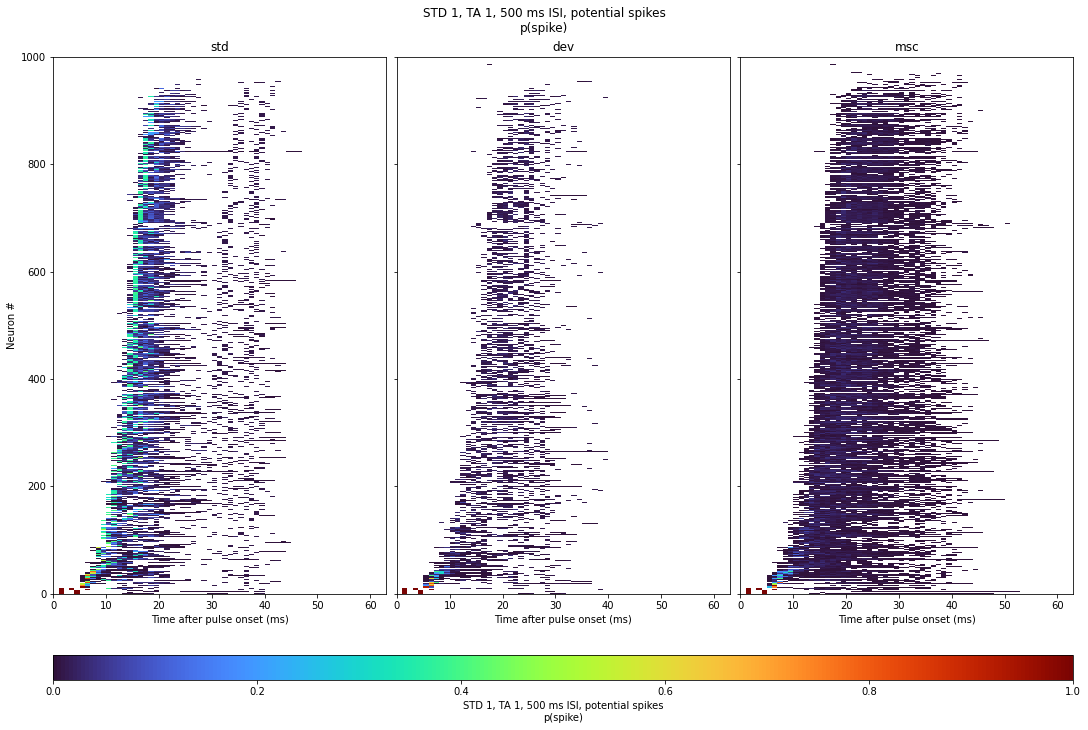

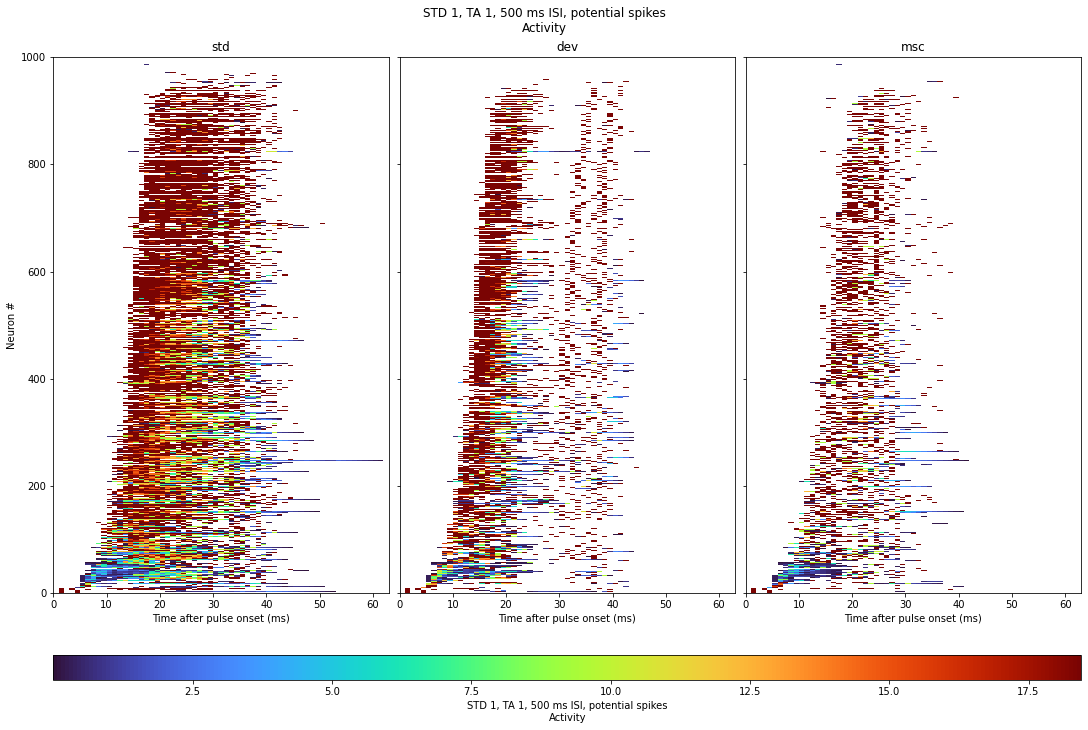

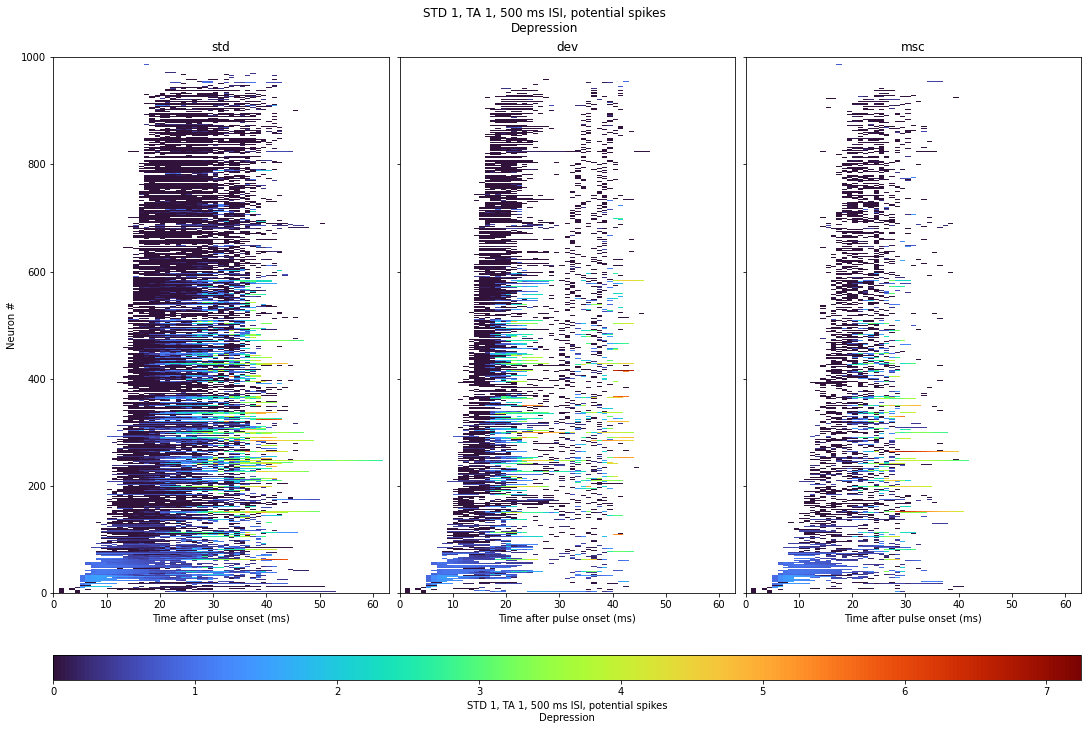

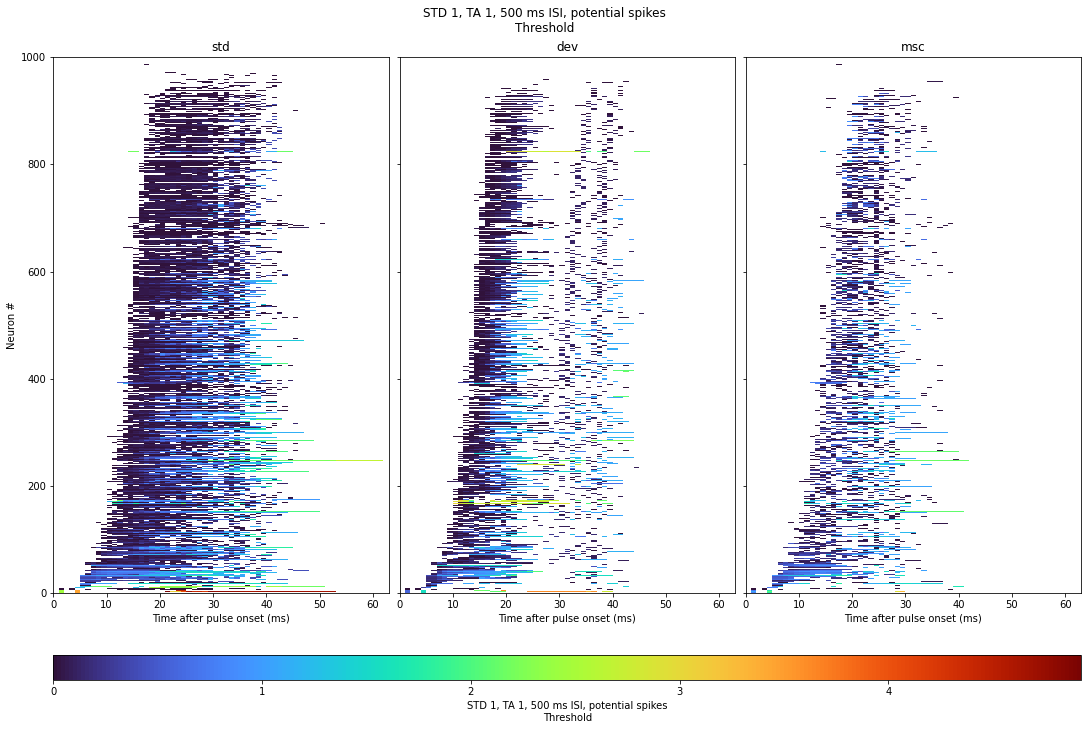

In [21]:
compare_raw(V, H, f'{title}, potential spikes', True)

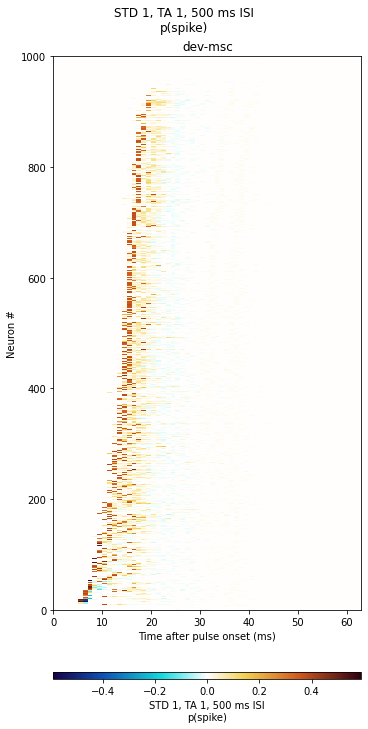

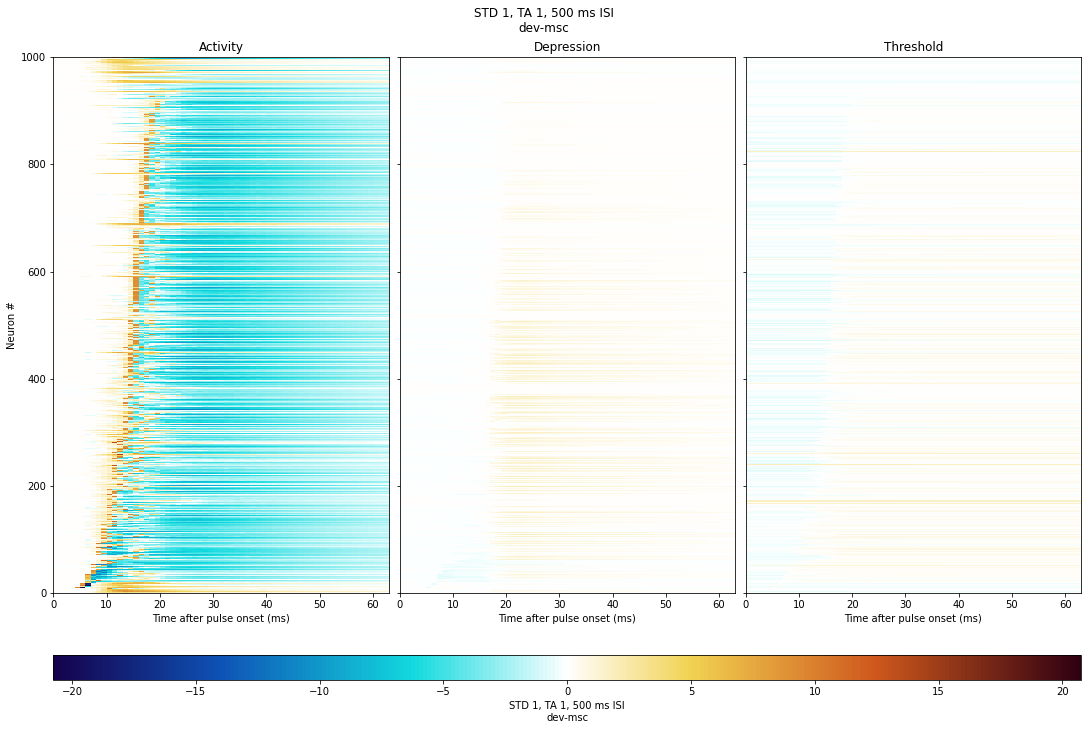

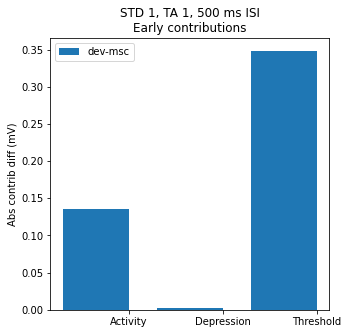

In [22]:
compare_direct(V, H, (('dev', 'msc'),), title, False)

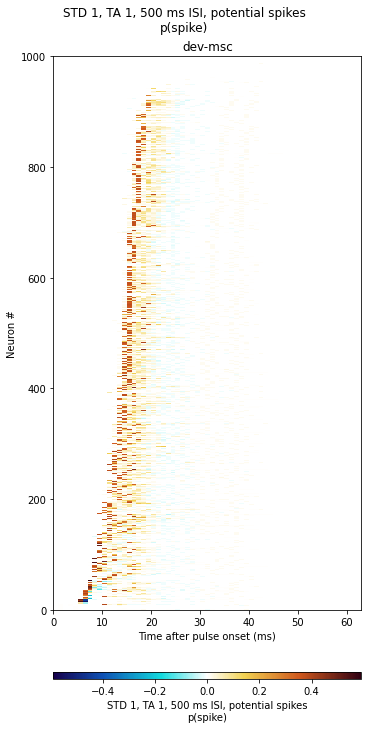

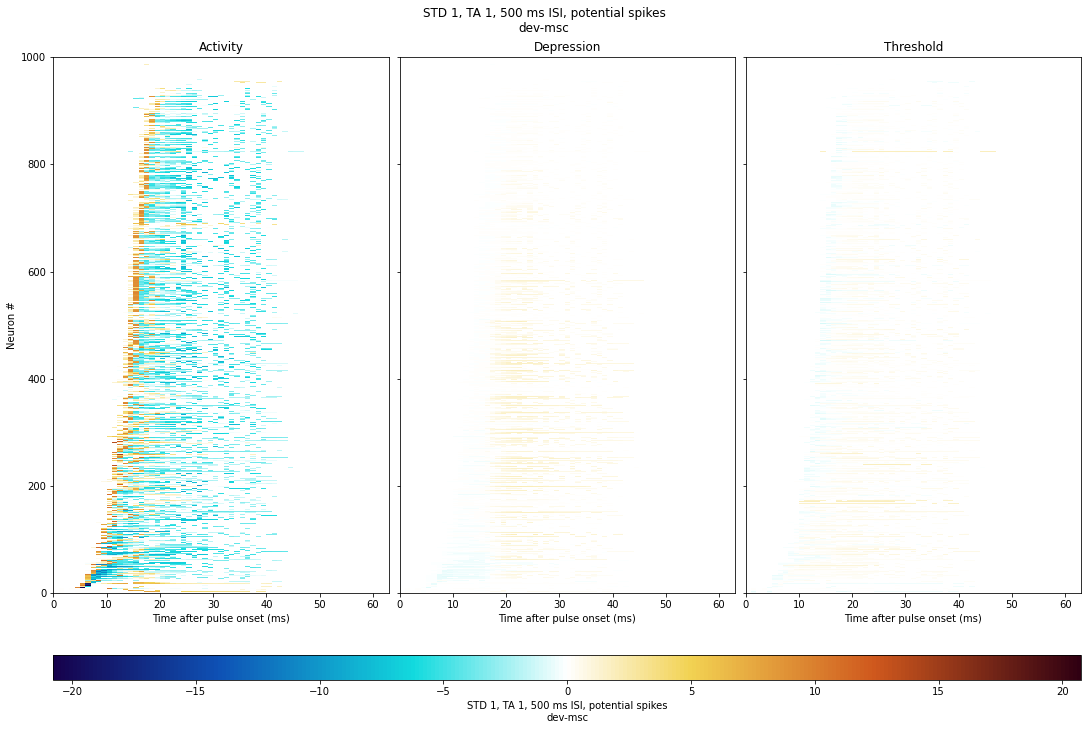

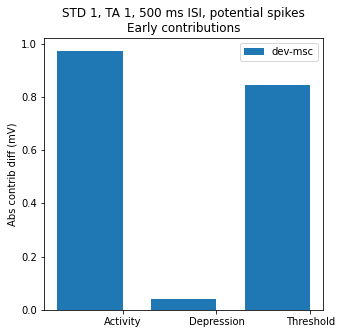

In [23]:
compare_direct(V, H, (('dev', 'msc'),), f'{title}, potential spikes', True)

## ISI: medium-short

In [24]:
V = {f'{isi} ms ISI': voltages[1][1][isi]['dev'] for isi in (500, 100)}
H = {f'{isi} ms ISI': results[1][1][isi]['dev']['spike_hist'] for isi in (500, 100)}
C = (tuple(V.keys()),)
title = 'STD 1, TA 1, deviant'

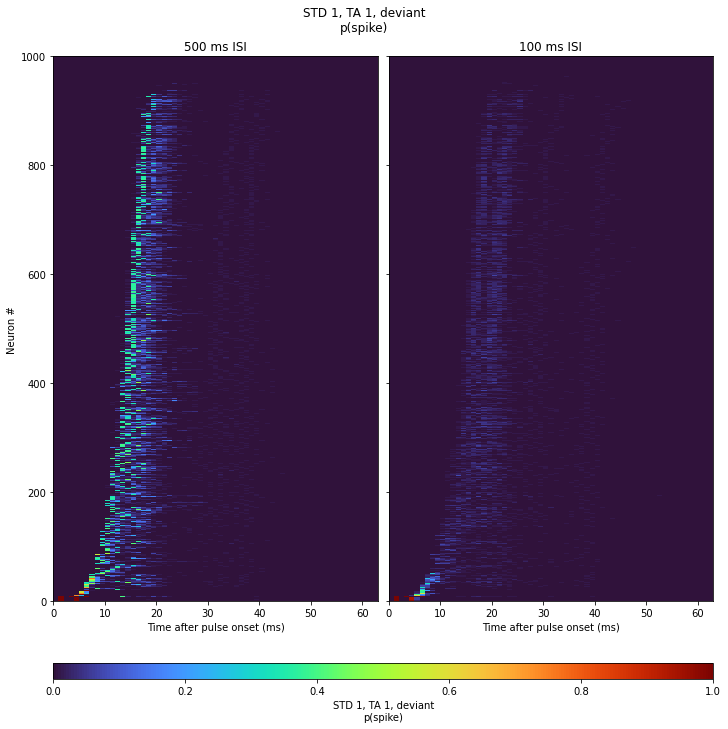

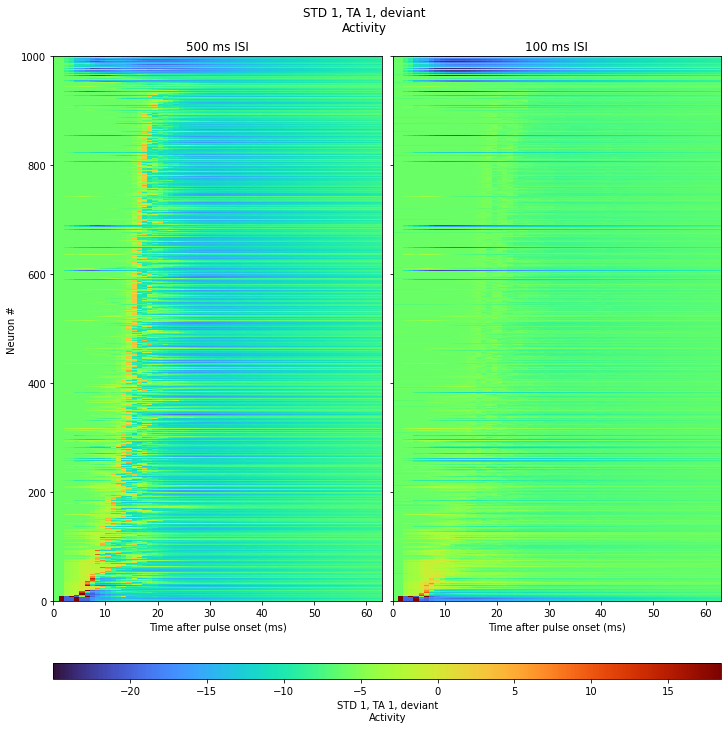

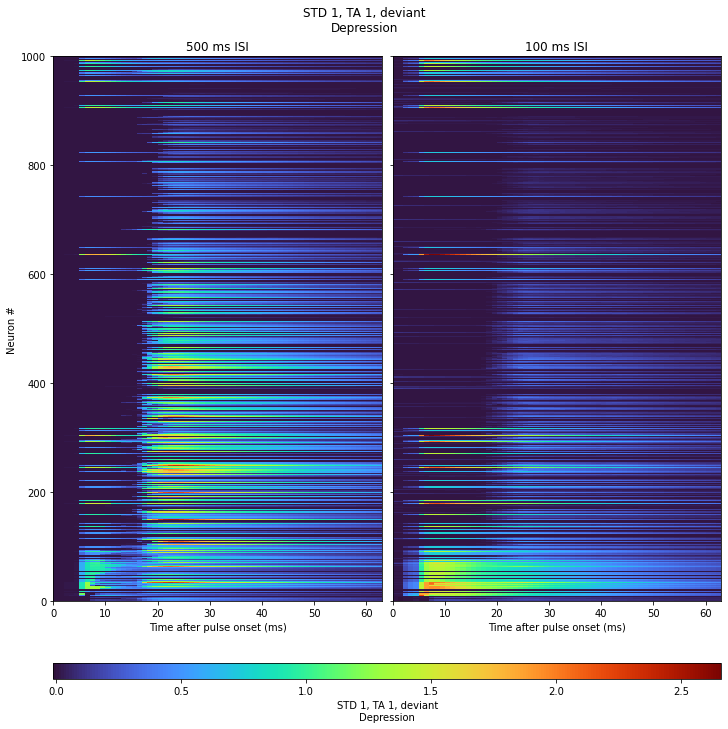

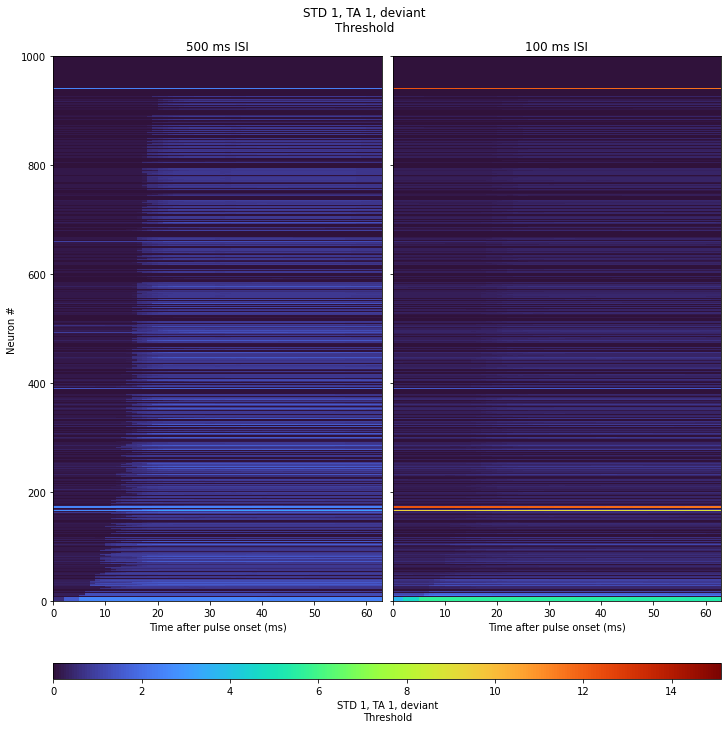

In [25]:
compare_raw(V, H, title, False)

WARNING    /tmp/ipykernel_134217/1179753402.py:25: RuntimeWarning: Mean of empty slice
  [np.nanmean(v[measure] * m, 1) for v, m in zip(voltages.values(), masks)], selection, tmax,
 [py.warnings]


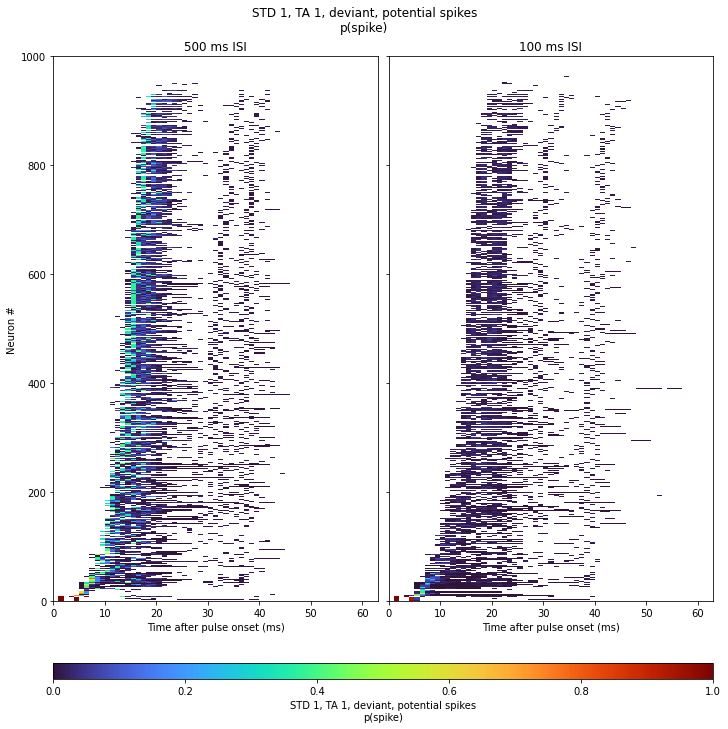

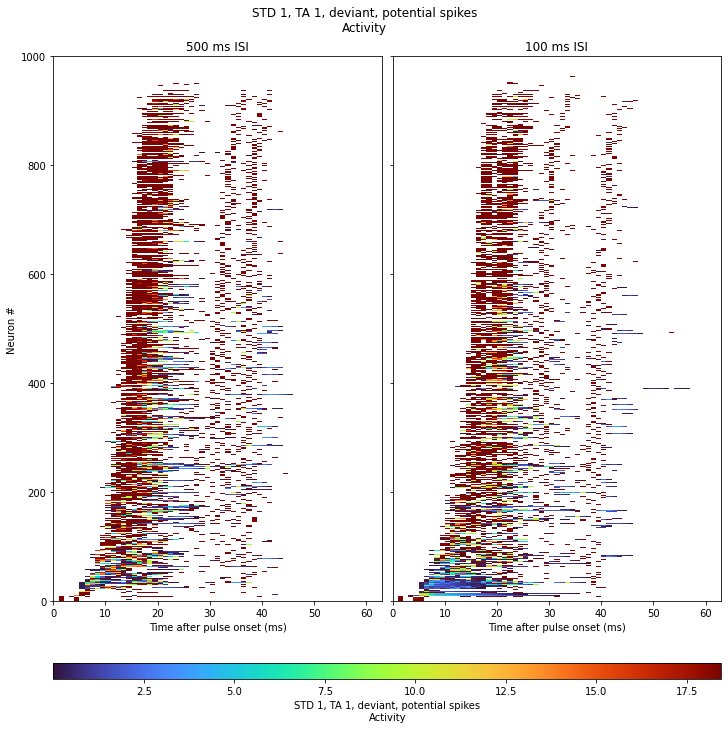

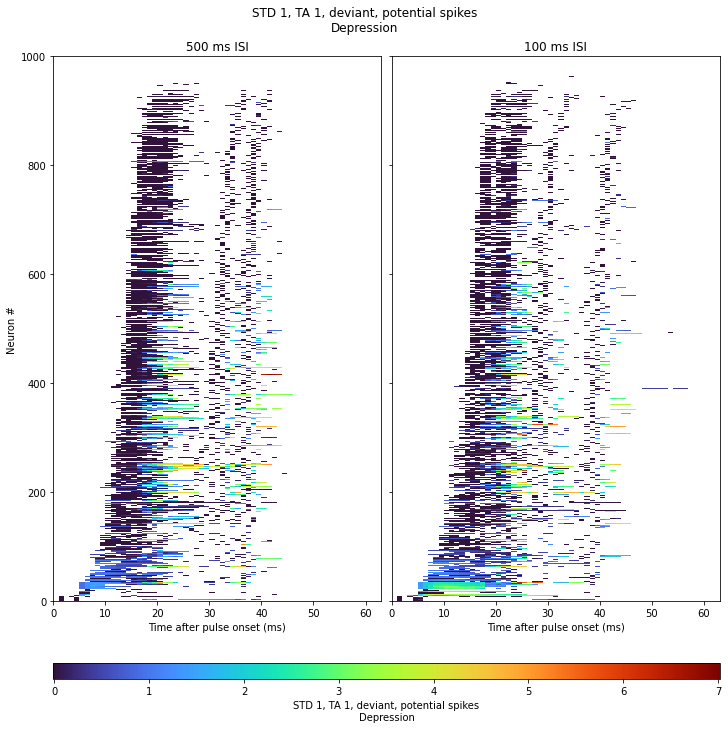

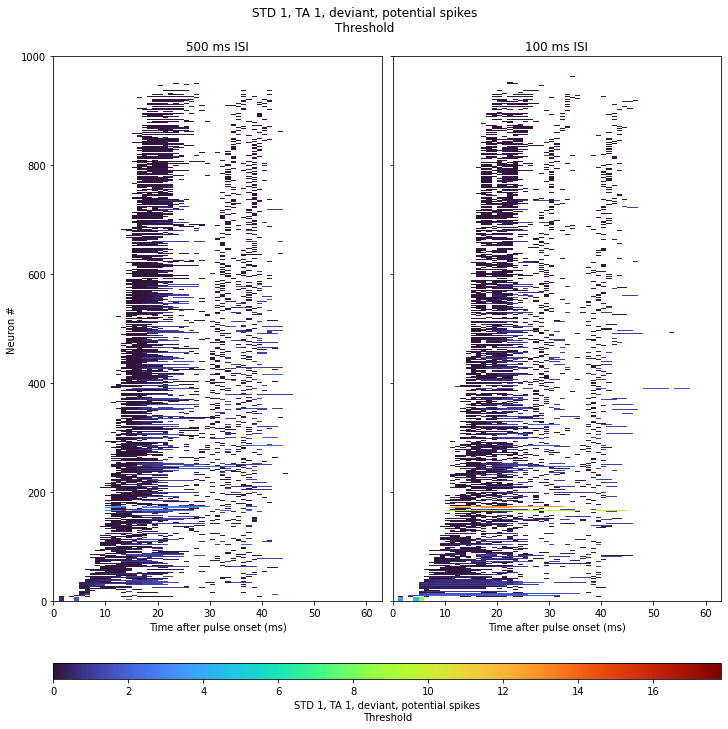

In [26]:
compare_raw(V, H, f'{title}, potential spikes', True)

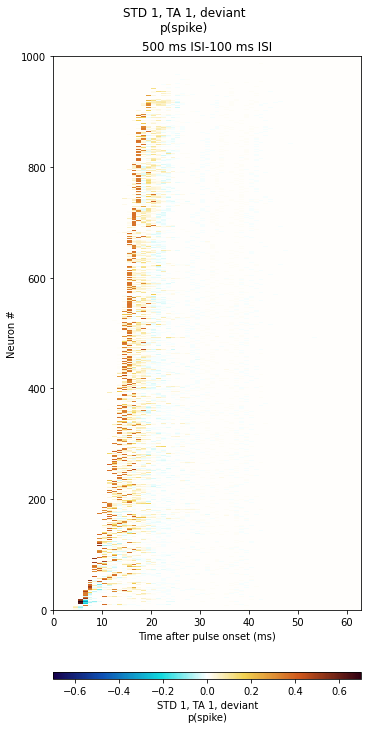

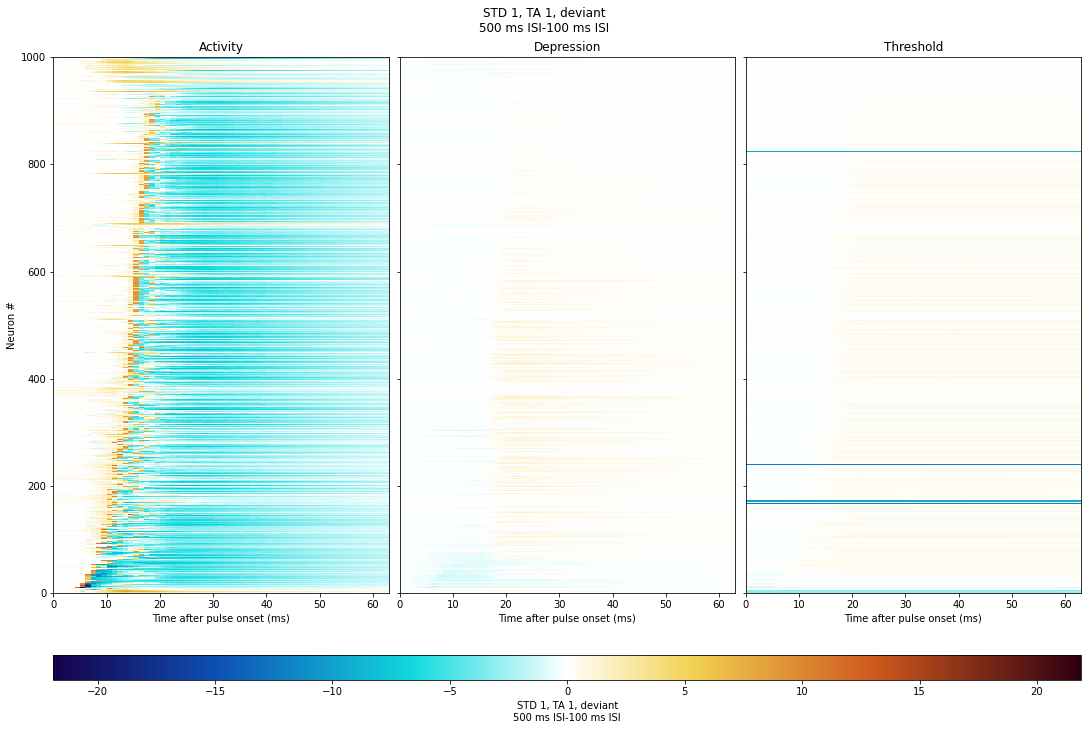

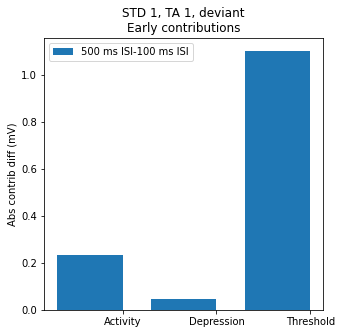

In [27]:
compare_direct(V, H, C, title, False)

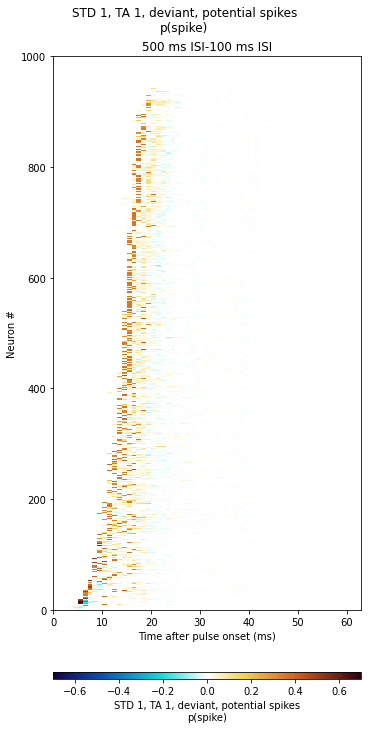

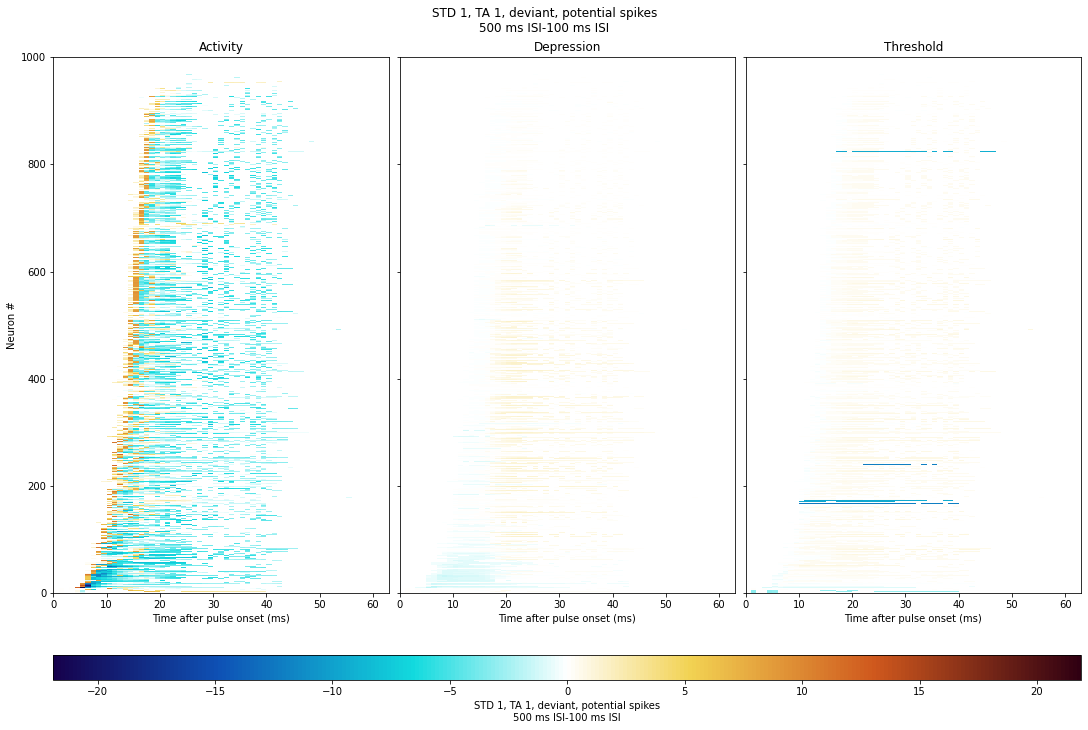

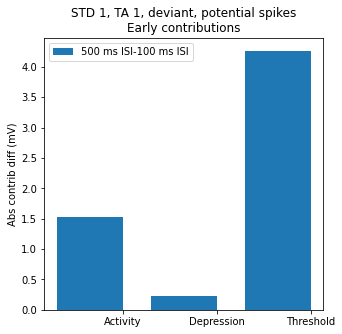

In [28]:
compare_direct(V, H, C, f'{title}, potential spikes', True)

## STD 1 - STD 0: Deviant and control

In [29]:
V = {f'STD {STD} {cond}': voltages[STD][1][500][cond] for cond in ('dev', 'msc') for STD in range(2)}
H = {f'STD {STD} {cond}': results[STD][1][500][cond]['spike_hist'] for cond in ('dev', 'msc') for STD in range(2)}
C = [(f'STD 1 {cond}', f'STD 0 {cond}') for cond in ('dev', 'msc')]
title = 'TA 1, 500 ms ISI'

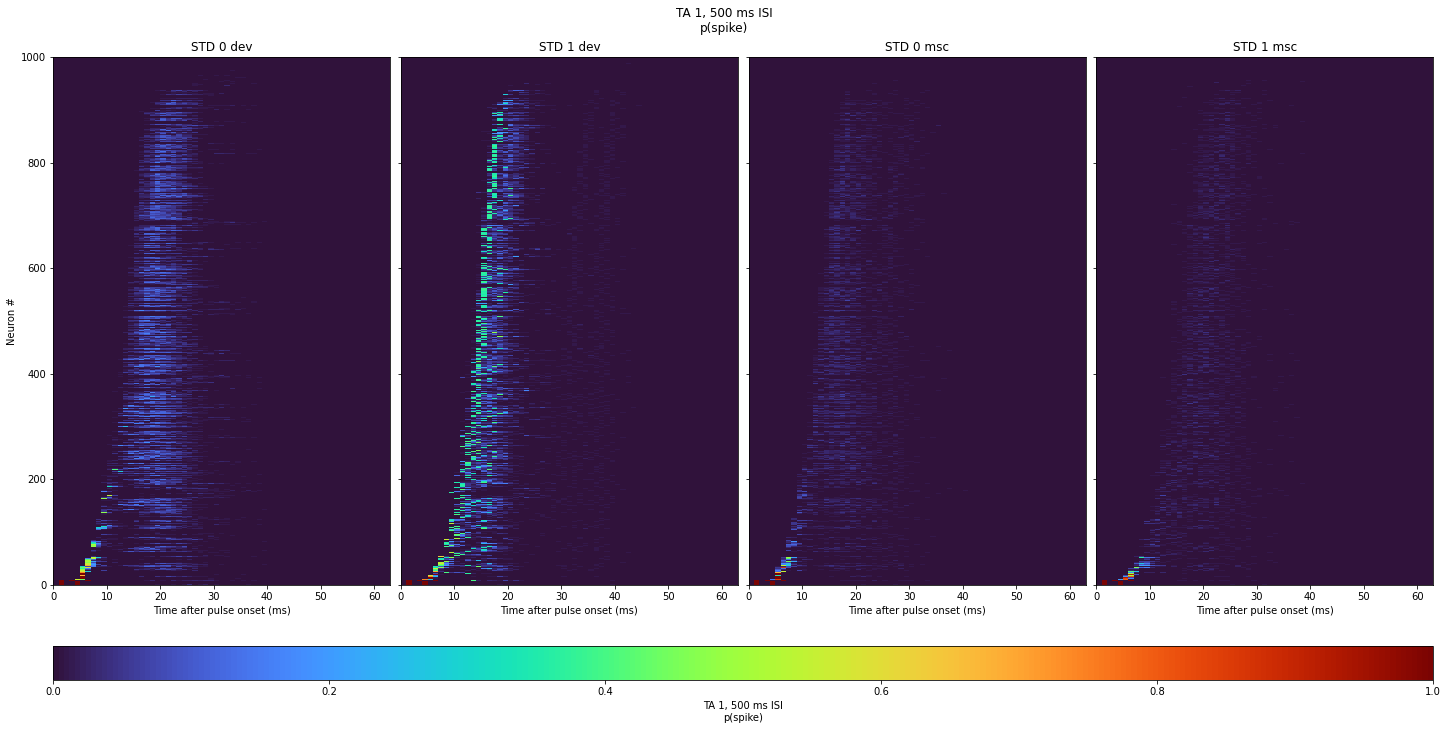

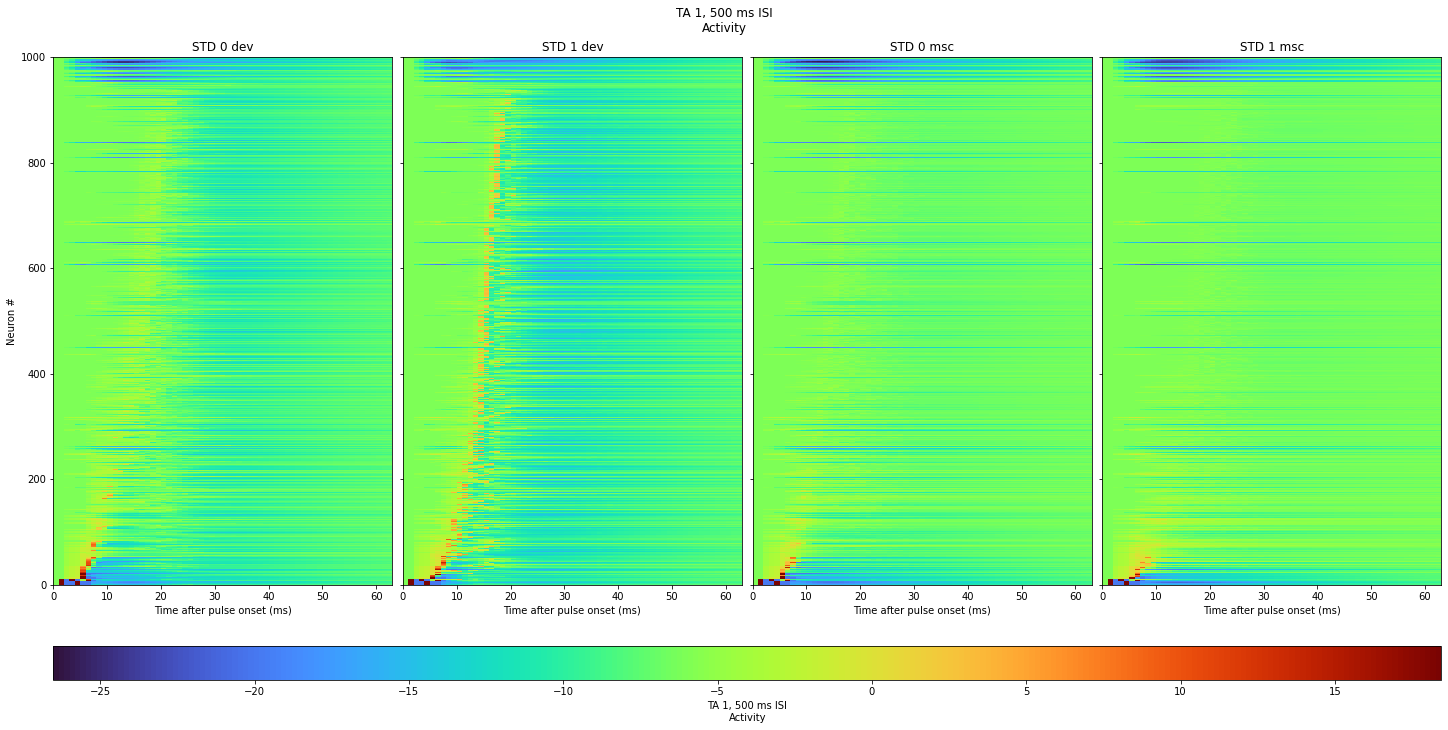

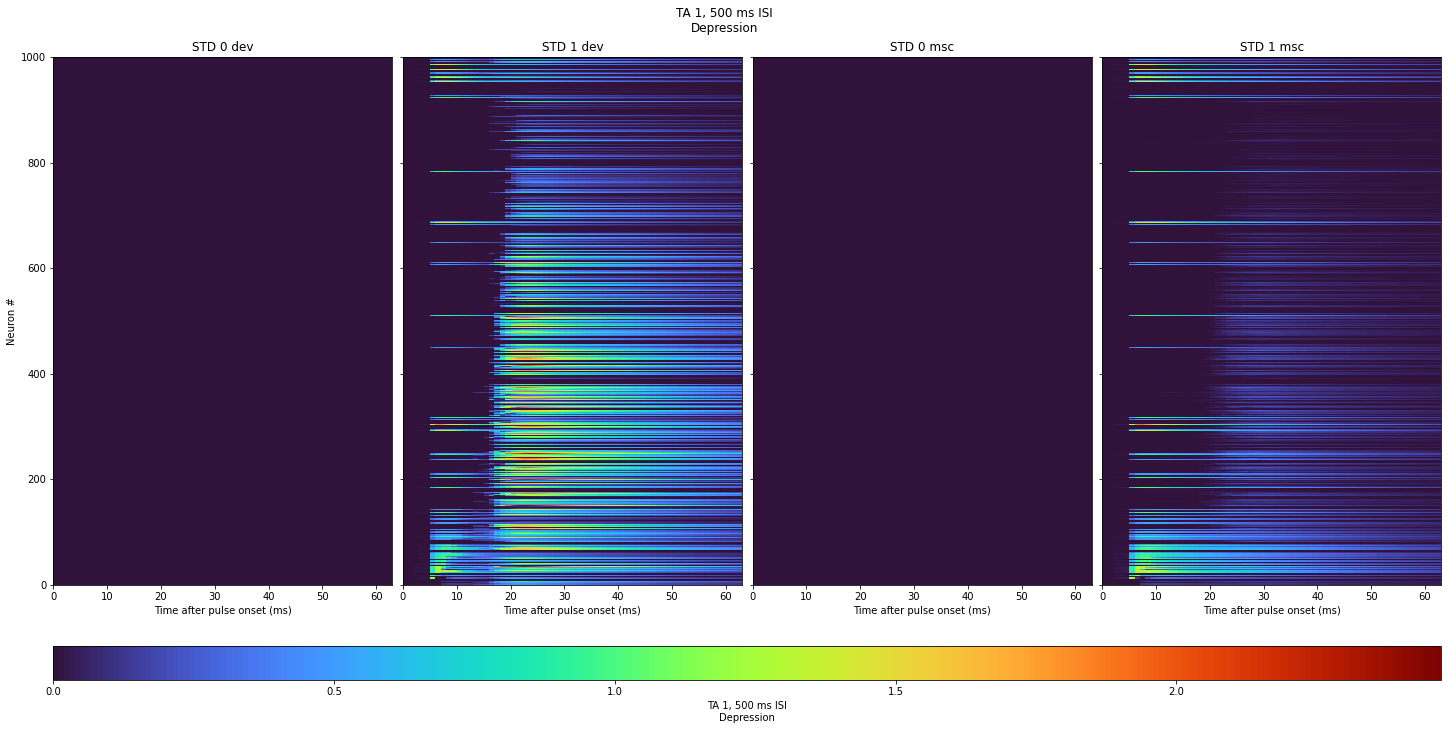

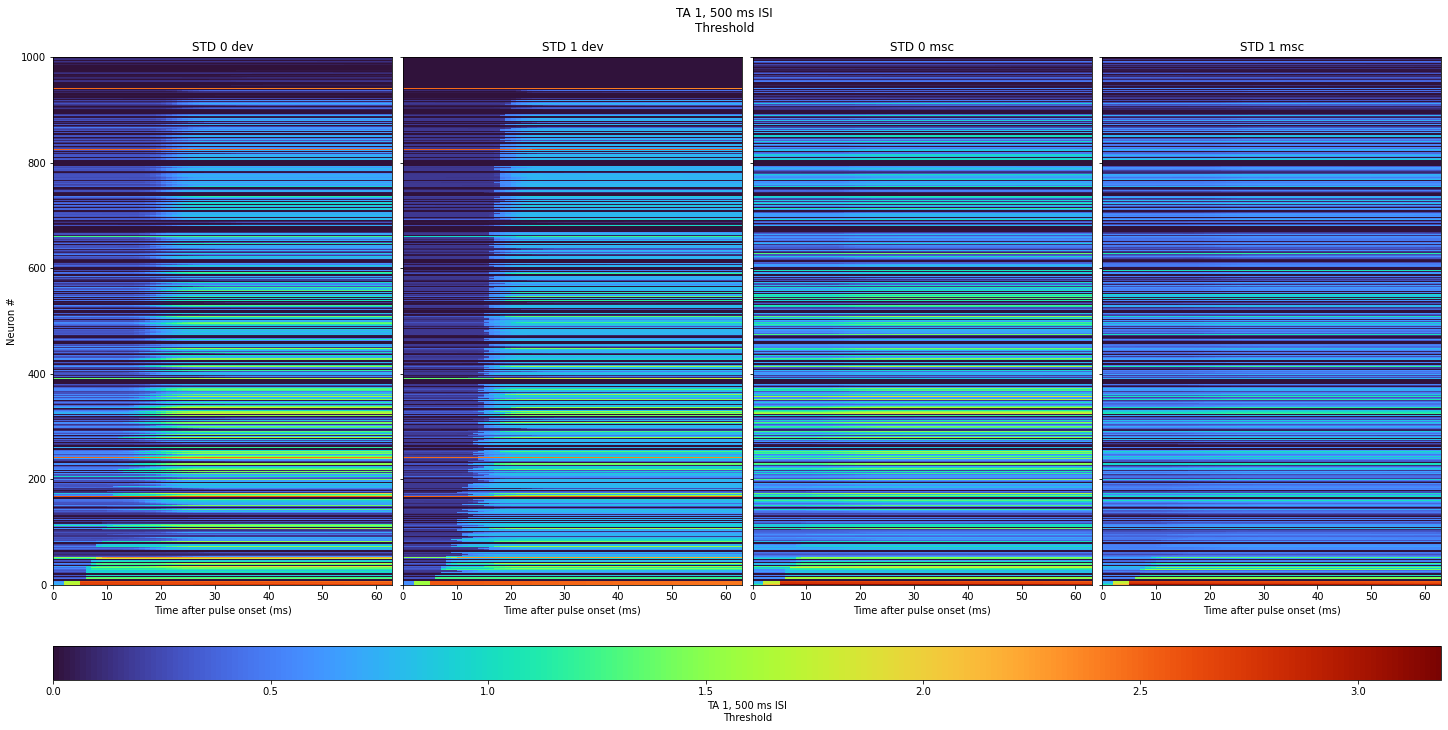

In [30]:
compare_raw(V, H, title, False)

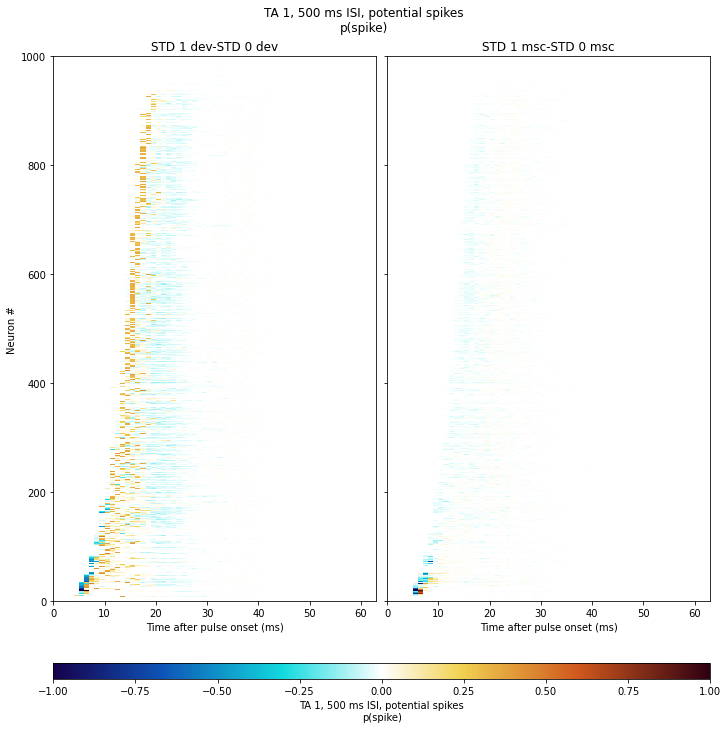

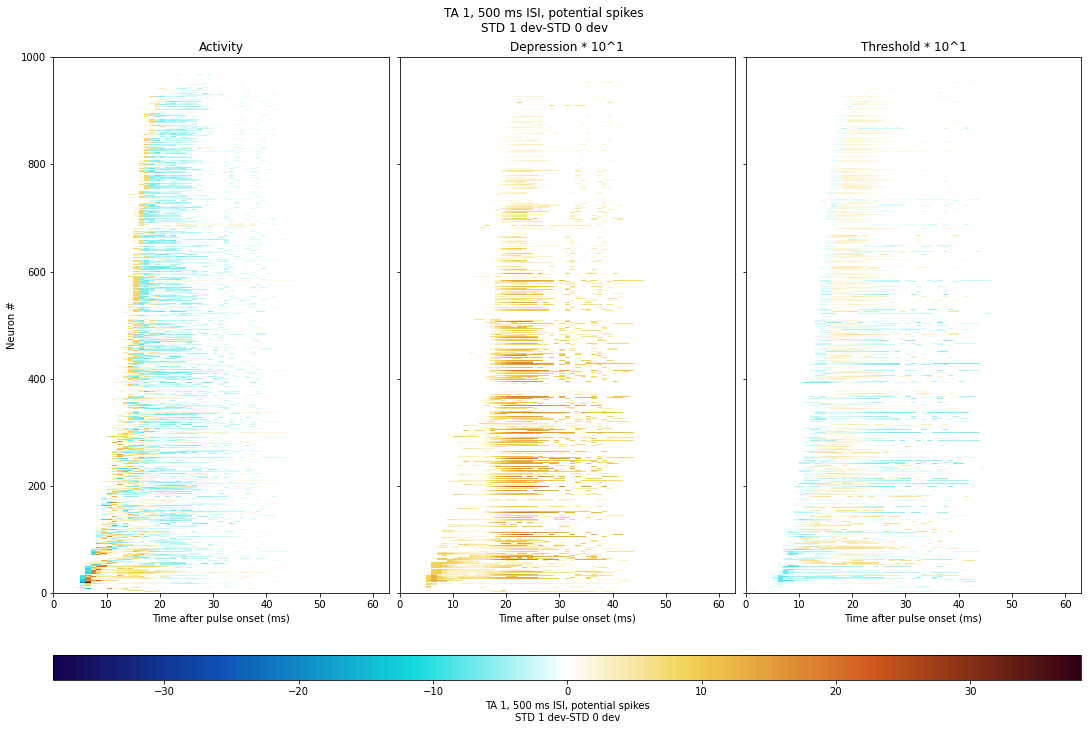

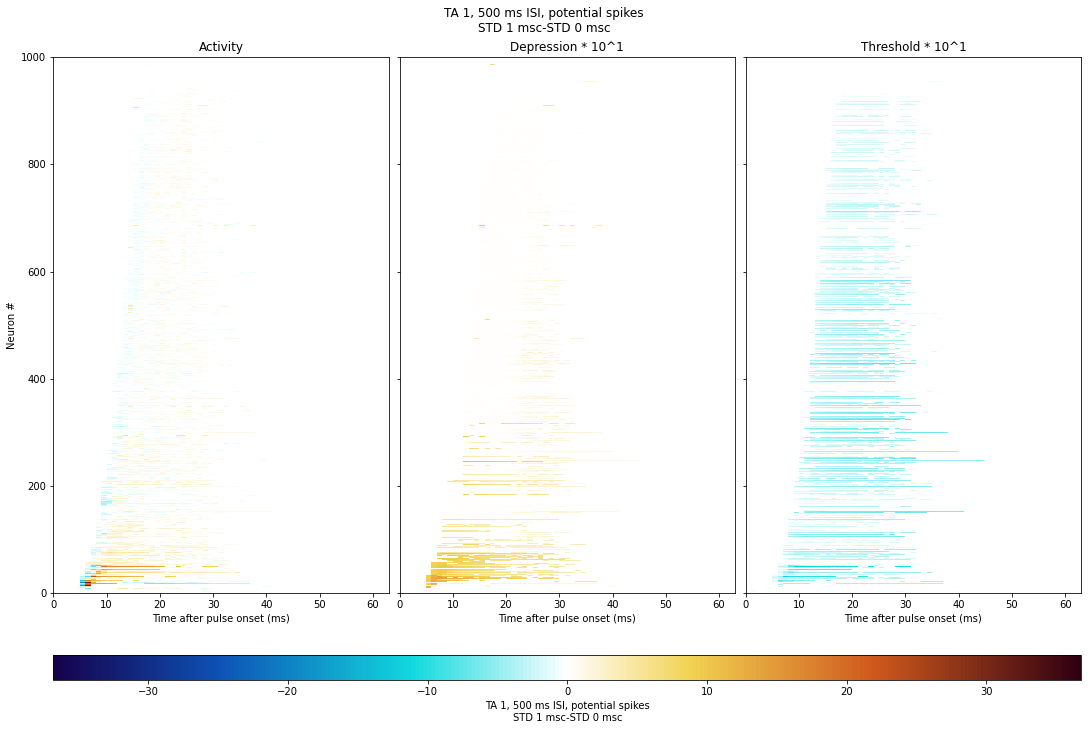

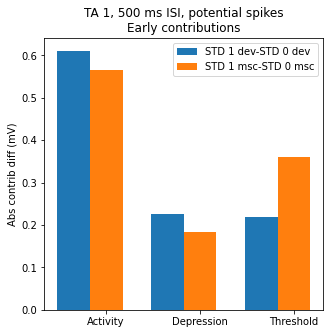

In [31]:
compare_direct(V, H, C, f'{title}, potential spikes', True)

## TA 1 - TA 0

In [32]:
V = {f'TA {TA} {cond}': voltages[1][TA][500][cond] for cond in ('dev', 'msc') for TA in range(2)}
H = {f'TA {TA} {cond}': results[1][TA][500][cond]['spike_hist'] for cond in ('dev', 'msc') for TA in range(2)}
C = [(f'TA 1 {cond}', f'TA 0 {cond}') for cond in ('dev', 'msc')]
title = 'STD 1, 500 ms ISI'

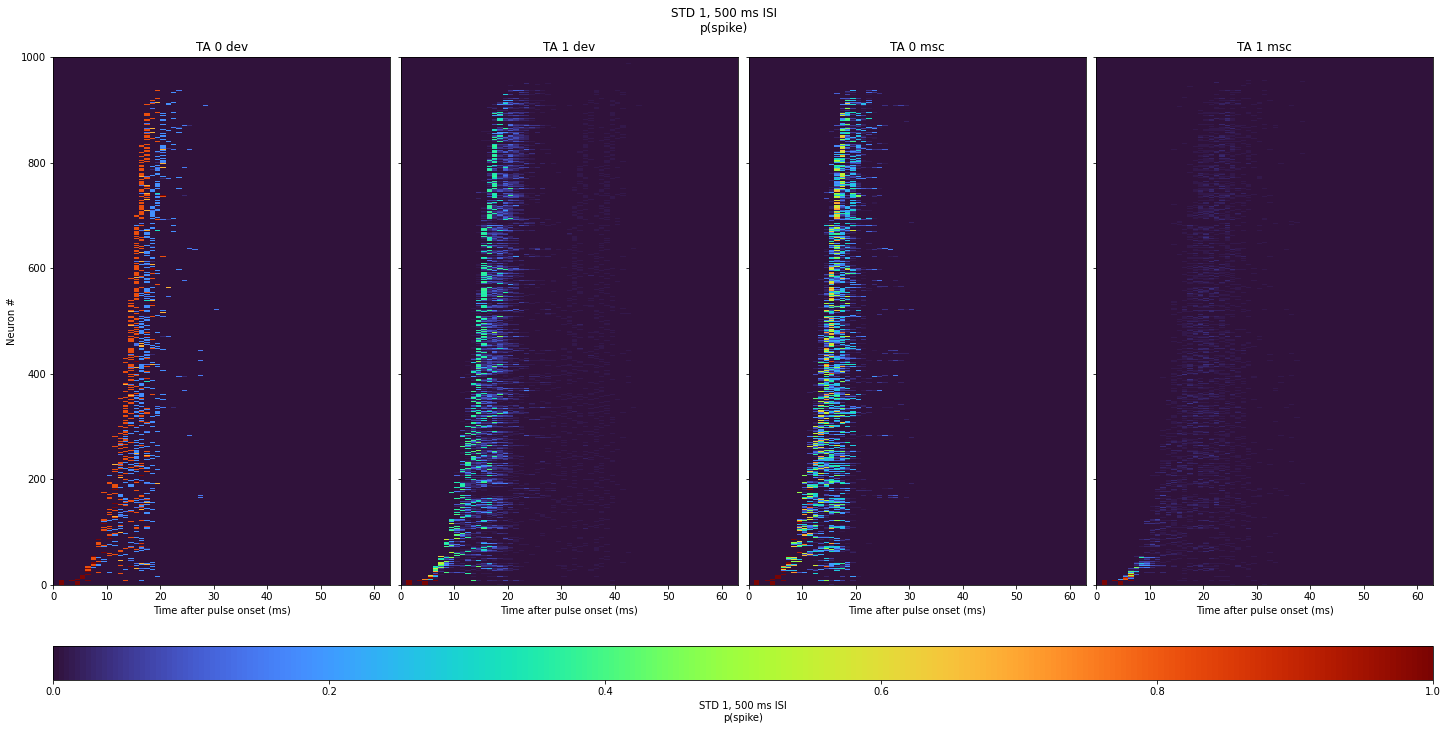

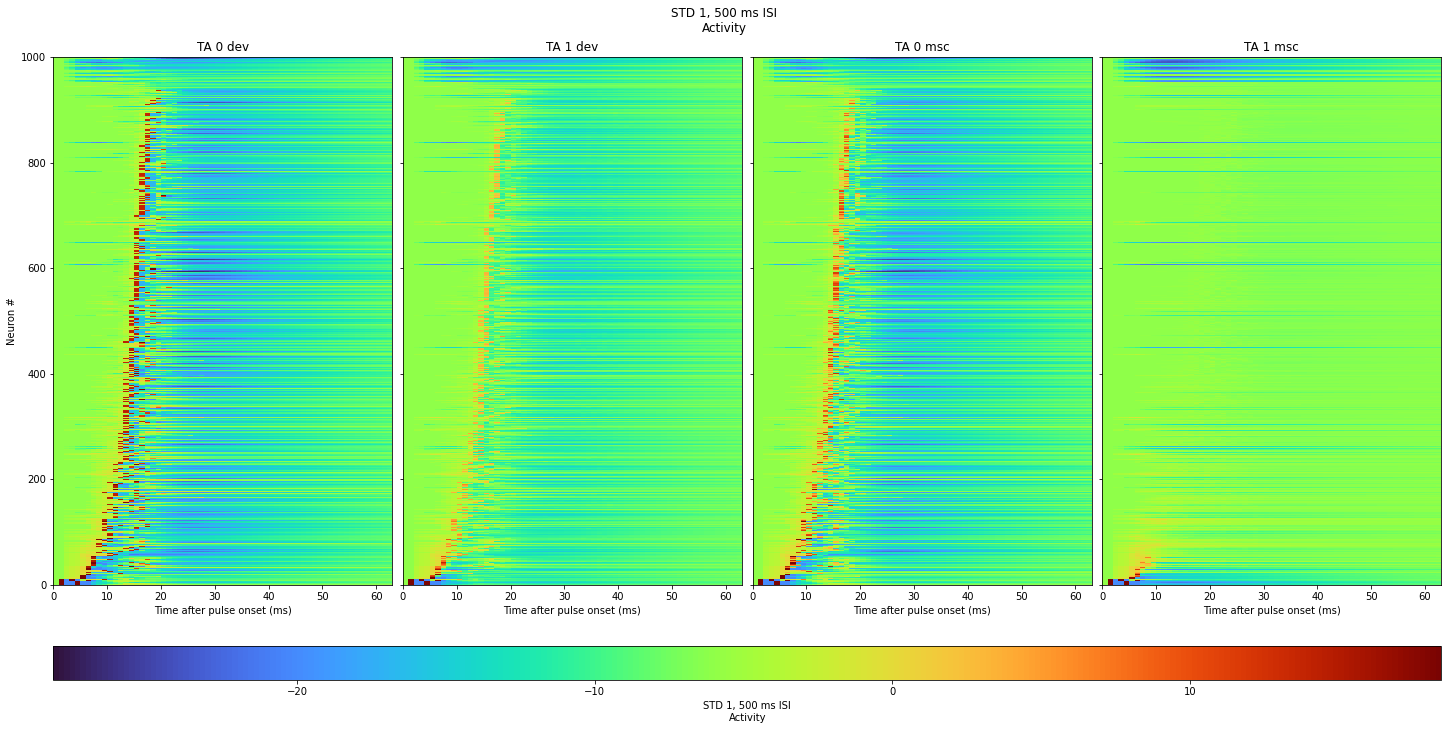

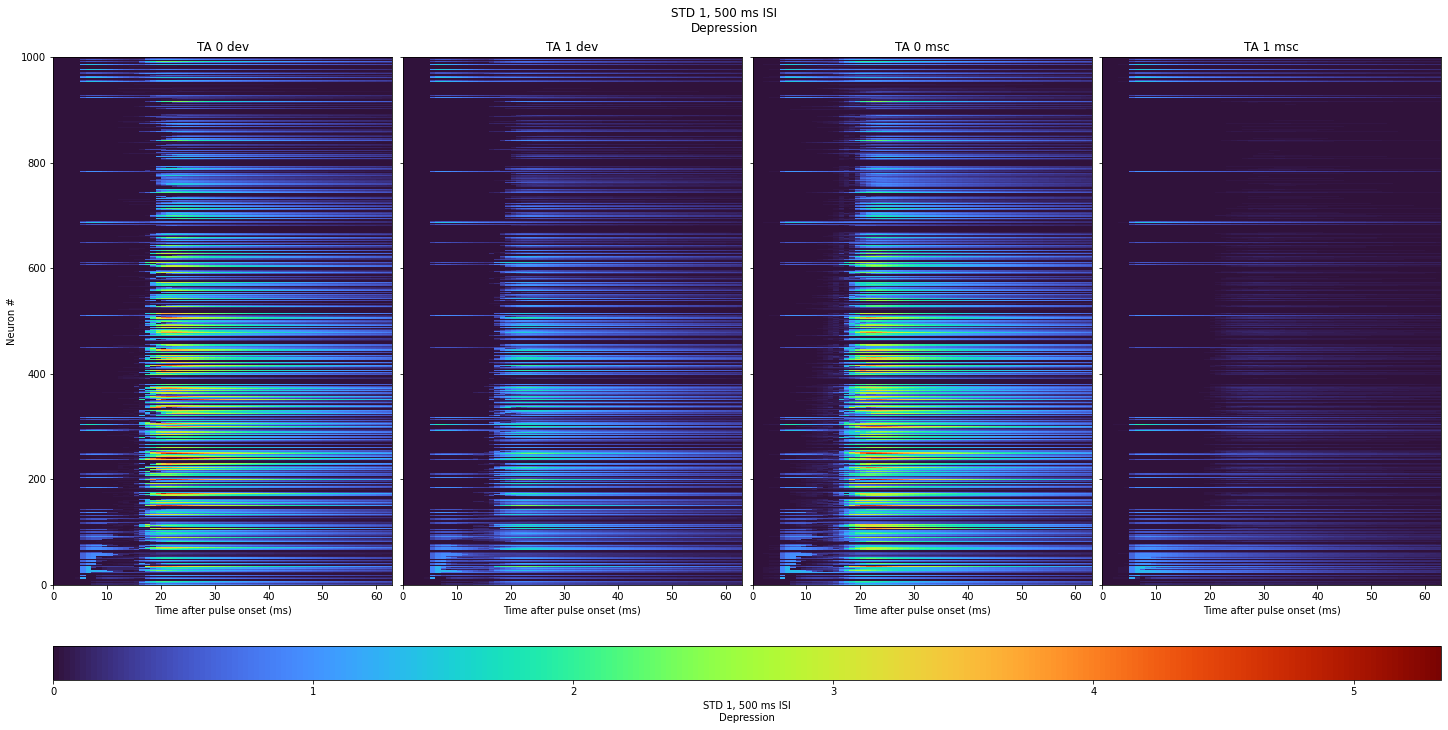

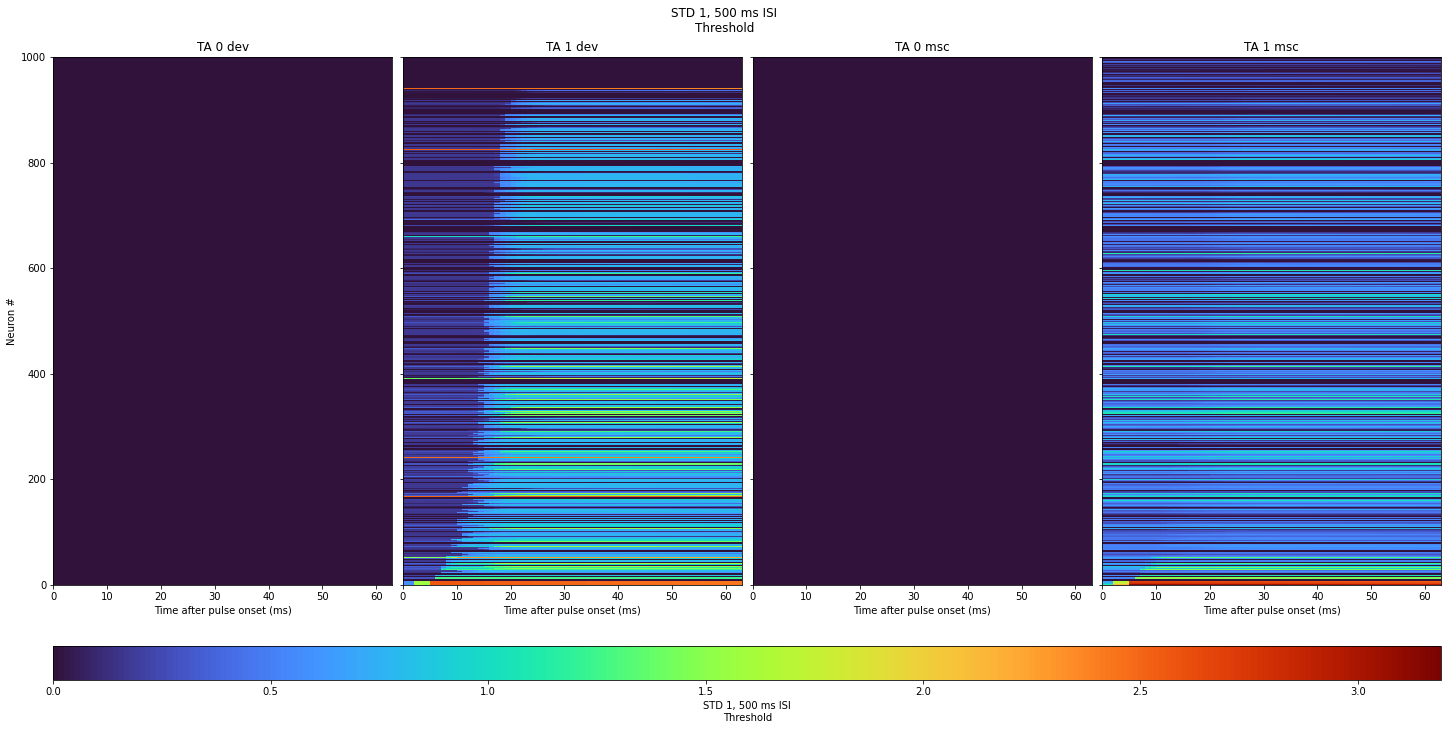

In [33]:
compare_raw(V, H, title, False)

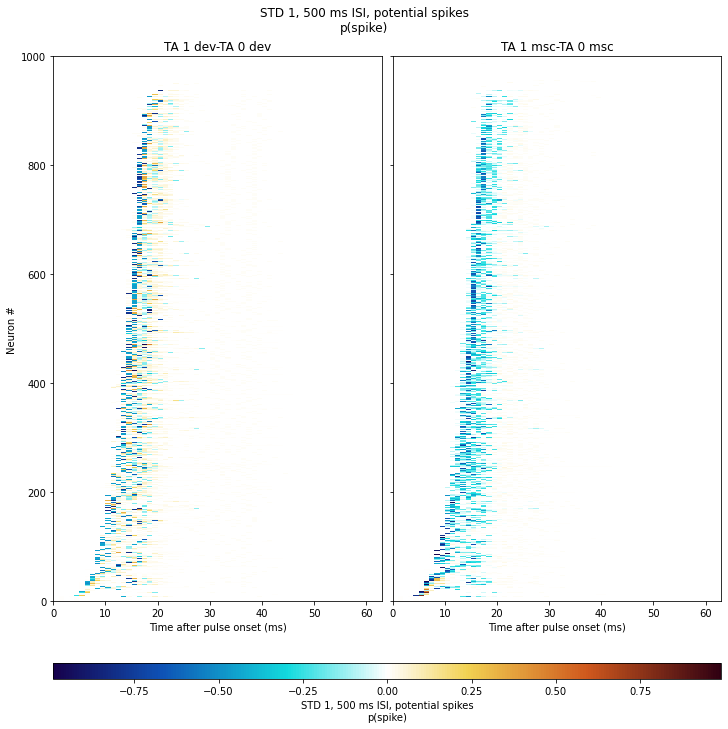

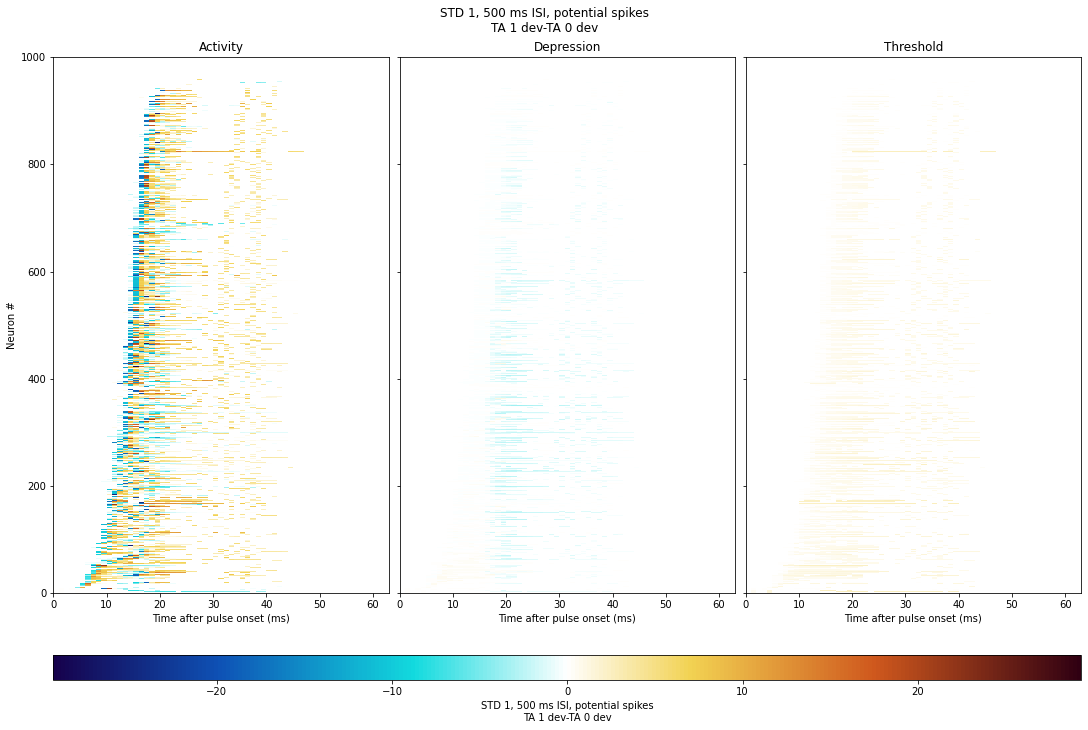

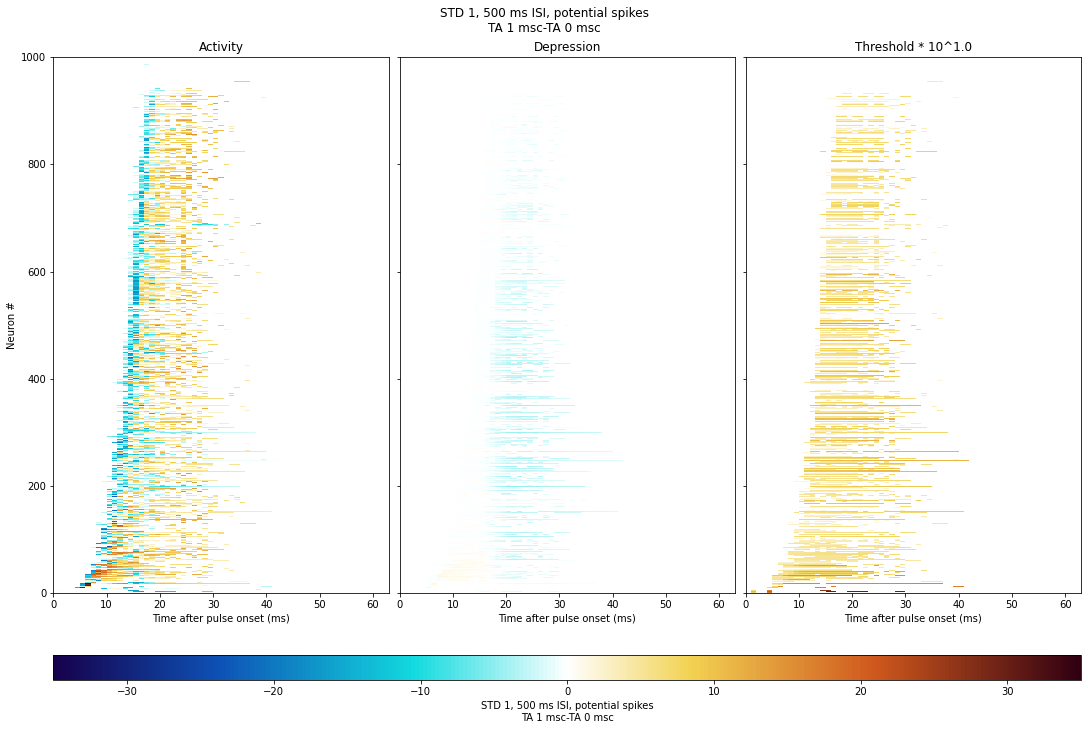

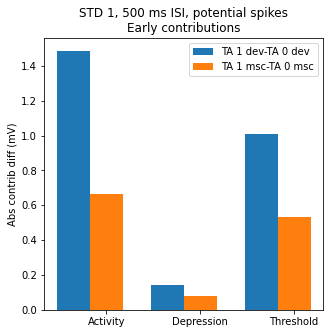

In [34]:
compare_direct(V, H, C, f'{title}, potential spikes', True)